In [1]:
## Technical comments:
# Adding Kernel size larger than 3*3 is better.
# Very deep network lead to bad trainig process.
# Component-wise Scaling component of loss (which is div(sigma)) was very effective.
# Increasing number of sample causes local minimum and we have to use a bigger network for them.
# Shape of loss affected the training. Taking average on what? sample(no!), cell, component or all? 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import pandas as pds
import pickle
from distutils.dir_util import mkpath
from multiprocessing import Pool
from time import time
import tensorflow as tf 
import math
import os
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

unsupervised = True

from tensorflow.keras import backend as K
import timeit



In [3]:
def stack_uneven(arrays, fill_value=0.):
    '''
    Fits arrays into a single numpy array, even if they are
    different sizes. `fill_value` is the default value.

    Args:
            arrays: list of np arrays of various sizes
                (must be same rank, but not necessarily same size)
            fill_value (float, optional):

    Returns:
            np.ndarray
    '''
    sizes = [a.shape for a in arrays]
    max_sizes = np.max(list(zip(*sizes)), -1)
    # The resultant array has stacked on the first dimension
    result = np.full((len(arrays),) + tuple(max_sizes), fill_value)
    for i, a in enumerate(arrays):
      # The shape of this array `a`, turned into slices
      slices = tuple(slice(0,s) for s in sizes[i])
      # Overwrite a block slice of `result` with this array `a`
      result[i][slices] = a
    return result

In [4]:
nSample = 500
percent_test = 10

ratio=1


#scaleType="variable"#"var_loc"

scaleType="variable"

path=ath=os.getcwd()

#DL_files = glob(path+'/*/DL*.dat')
#np.random.shuffle(DL_files)
#print(len(DL_files))

In [5]:
def flat2RawShape(flatShape,maxI,maxJ):
    rawData=np.transpose(flatShape.reshape(-1,maxI*maxJ))
    return rawData

def raw2SpaceShape(rawShape,maxI,maxJ):
    dataReshaped=rawShape.reshape(maxI,maxJ,-1)
    return dataReshaped

def flat2SpaceShape(flatShape,maxI,maxJ):
    rawData=flat2RawShape(flatShape,maxI,maxJ)
    spaceShaped=raw2SpaceShape(rawData,maxI,maxJ)
    return spaceShaped

def space2RawShape(spaceShape,maxI,maxJ):
    #print(spaceShape.shape)
    rawSahped=spaceShape.reshape(maxI*maxJ,-1)
    return rawSahped

def raw2FlatShape(Shape,maxI,maxJ):
    #print(spaceShape.shape)
    flatSahped=np.transpose(Shape)[:Shape.shape[1],:].reshape(1,-1)
    return flatSahped

def scaled2Raw(scaledData,maxI,maxJ):
    with open('training_scalers.pkl','rb') as f:
        scaler_data_l = pickle.load(f)
    try:
        scaler_y=scaler_data_l['scaler_y']
        data_scaled_flat=[]
        data_scaled_raw=[]
        if scaledData.ndim<4:
            data_scaled_raw.append(space2RawShape(scaledData,maxI,maxJ))
            data_scaled_flat.append(raw2FlatShape(data_scaled_raw[0],maxI,maxJ))
        else:
            for i in range(0,scaledData.shape[0]):
                data_scaled_raw.append(space2RawShape(scaledData[i],maxI,maxJ))
                data_scaled_flat.append(raw2FlatShape(data_scaled_raw[i],maxI,maxJ))
        if scaleType=="var_loc":
            data_scaled_flat=np.concatenate(data_scaled_flat,0)
            data_flat=scaler_y.inverse_transform(data_scaled_flat)
            data_raw=np.apply_along_axis(flat2RawShape,1,data_flat,maxI,maxJ)

        elif scaleType=="variable":
            data_scaled_raw=np.concatenate(data_scaled_raw,0)
            data_raw=scaler_y.inverse_transform(data_scaled_raw)
            data_raw=data_raw.reshape(scaledData.shape[0],maxI*maxJ,-1)
    except:
        scaler_y=scaler_data_l['scaler_x']
        data_scaled_flat=[]
        data_scaled_raw=[]
        if scaledData.ndim<4:
            data_scaled_raw.append(space2RawShape(scaledData,maxI,maxJ))
            data_scaled_flat.append(raw2FlatShape(data_scaled_raw[0],maxI,maxJ))
        else:
            for i in range(0,scaledData.shape[0]):
                data_scaled_raw.append(space2RawShape(scaledData[i],maxI,maxJ))
                data_scaled_flat.append(raw2FlatShape(data_scaled_raw[i],maxI,maxJ))
        if scaleType=="var_loc":
            data_scaled_flat=np.concatenate(data_scaled_flat,0)
            data_flat=scaler_y.inverse_transform(data_scaled_flat)
            data_raw=np.apply_along_axis(flat2RawShape,1,data_flat,maxI,maxJ)

        elif scaleType=="variable":
            data_scaled_raw=np.concatenate(data_scaled_raw,0)
            data_raw=scaler_y.inverse_transform(data_scaled_raw)
            data_raw=data_raw.reshape(scaledData.shape[0],maxI*maxJ,-1)


    return data_raw
    


In [6]:
foam_path = glob(path+'/ml_dataset/*/')[:nSample]
np.random.shuffle(foam_path)

In [7]:
def readFoamData(files):
    X = []
    end = len(files)
    for i in range(0, len(files)):
        data = pds.read_csv(files[i],delim_whitespace = True).values
        X.append(data)
    X = np.stack( X, axis=0 )
    return X

def readAllFoamData(foamPath):
    cellCoeffData = []
    cellNeiData = []
    bTracData = []
    bFixedData = []
    dispData = []
    bTractionDispData = []
    XData = []
    YData = []
    intrpAddrData = []
    intrpWeiData = []

    for i in range(0, len(foamPath)):
        #print(foamPath)
        data = pds.read_csv(glob(foamPath[i]+'/*/cellCo*.dat')[0],delim_whitespace = True).values
        cellCoeffData.append(data)
        data = pds.read_csv(glob(foamPath[i]+'/*/cellNe*.dat')[0],delim_whitespace=True).values.astype(int)
        cellNeiData.append(data)
        data = pds.read_csv(glob(foamPath[i]+'/*/bFix*.dat')[0],delim_whitespace = True).values
        bFixedData.append(data)
        data = pds.read_csv(glob(foamPath[i]+'/*/bTrac*.dat')[0],delim_whitespace = True).values
        bTracData.append(data)
        data = pds.read_csv(glob(foamPath[i]+'/*/Disp*.dat')[0],delim_whitespace = True).values
        dispData.append(data)
        
        data = pds.read_csv(glob(foamPath[i]+'/*/interpAdd*.dat')[0],delim_whitespace = True).values.astype(int)
        intrpAddrData.append(data)
        data = pds.read_csv(glob(foamPath[i]+'/*/interpWe*.dat')[0],delim_whitespace = True).values
        intrpWeiData.append(data)
        
        #data = pds.read_csv(glob(foamPath[i]+'/*/bTrDisp*.dat')[0],delim_whitespace = True).values
        bTractionDispData.append(data)
 
        #i_entry = 0
        time_step_data = pds.read_csv(glob(foamPath[i]+'/*/inputCaseCrt*.dat')[0],delim_whitespace = True)
        maxJ=int(time_step_data.iloc[-1]["IndexJ"]+1)
        maxI=int(time_step_data.iloc[-1]["IndexI"]+1)
        feature_columns_name=["IndexI","IndexJ"]#,"Dx","Fx"]#,"CellX","CellY","Fx","Fy"]
        popK=len(feature_columns_name)
        for kk in range(0,popK):
            popData=time_step_data.pop(feature_columns_name[kk])
        data_values=time_step_data.values
        nCol=data_values.shape[0]/2
        data_reshaped=raw2SpaceShape(data_values,maxI,maxJ)
        if scaleType=="variable":
            X_data=data_values[:,:data_values.shape[1]-2]
            Y_data=data_values[:,data_values.shape[1]-2:]
        elif scaleType=="var_loc":
            X_data=np.transpose(data_values)[:data_values.shape[1]-2,:].reshape(-1)
            Y_data=np.transpose(data_values)[data_values.shape[1]-2:,:].reshape(-1)
        XData.append(X_data)
        YData.append(Y_data)
    cellCoeffData = stack_uneven( cellCoeffData, 0.0)
    #print(cellCoeffData.shape)
    cellNeiData = stack_uneven( cellNeiData, 0 ).astype(int)
    bFixedData = stack_uneven( bFixedData, 0.0 )
    bTracData = stack_uneven( bTracData, 0.0 )
    bTracData[bTracData[:,:,7] == 0,7] = 1


    dispData = stack_uneven( dispData, 0.0 )

    intrpAddrData = stack_uneven(intrpAddrData, 0 ).astype(int)
    intrpWeiData = stack_uneven(intrpWeiData, 0.0 )

    bTractionDisp = stack_uneven(bTractionDispData, 0.0 )

    if scaleType == "var_loc":
        XData = stack_uneven(XData, 0.0)
        YData = stack_uneven(YData, 0.0)
    elif scaleType=="variable":
        XData = np.concatenate(XData)
        YData = np.concatenate(YData)

        

    cellCoeffData = cellCoeffData.reshape(cellCoeffData.shape[0],cellCoeffData.shape[1],-1,3)

    return cellCoeffData, cellNeiData, bFixedData, bTracData, dispData, XData,YData,\
                intrpAddrData, intrpWeiData, maxI,maxJ, bTractionDisp

#coeff_file = glob(path+'/ml_dataset/0.864_0.06311--569765.0_-865371.0/*/cellCo*.dat')
#nei_file = glob(path+'/ml_dataset/0.864_0.06311--569765.0_-865371.0/*/cellNei*.dat')
#bFixed_file = glob(path+'/ml_dataset/0.864_0.06311--569765.0_-865371.0/*/bFixed*.dat')
#bTrac_file = glob(path+'/ml_dataset/0.864_0.06311--569765.0_-865371.0/*/bTrac*.dat')
#disp_file = glob(path+'/ml_dataset/0.864_0.06311--569765.0_-865371.0/*/Disp*.dat')


cellCoeff, cellNei, bFixed, bTrac, disp_true, X,Y,intrpAddr,intrpWei, \
        maxI,maxJ, bTractionDisp = readAllFoamData(foam_path)






# scaling is done based on max.
maxXY=np.max(X[:,0:2])
maxBC=np.max(np.abs(X[:,2:]))
meanBC=np.mean(np.max(np.abs(X[:,2:]),axis=0))


maxY=np.max(np.abs(Y))

X_scaled = X
Y_scaled = Y

#X_scaled[:,0:2] = X[:,0:2]/maxXY
#X_scaled[:,3:] = X[:,3:]/maxBC
#Y_scaled = Y/maxY

X_scaled_spaced=X_scaled.reshape(len(foam_path),maxI,maxJ,-1)
Y_scaled_spaced=Y_scaled.reshape(len(foam_path),maxI,maxJ,-1)

#scalingFactor=1.0e5*maxBC/mu*ratio
disp_true_crt = Y.reshape([-1,maxI*maxJ,2])

if (bTrac.size == 0):
    bTrac=np.zeros([1,1,11])
    bTractionDisp = np.zeros([3])
    bTrac[0,0,7]=1.0
#print("old:",bFixed[10])
print(bTrac.shape)
print(bFixed.shape)
print(disp_true.shape)
print(cellNei.shape)
print(cellCoeff.shape)
print(X_scaled_spaced.shape)
print(Y_scaled_spaced.shape)
print(bTractionDisp.shape)
print(intrpAddr.shape)
print(intrpWei.shape)
print(Y.shape)
print(disp_true_crt.shape)


print(maxBC)
print(meanBC)
#print(scalingFactor)
#print(intrpWei)

## Because of type of reshaping in div and grad functions
#for i in range(1,bTrac.shape[0]):
#    bTrac[i,:,0] += i*cellCoeff.shape[1]
#for i in range(1,bFixed.shape[0]):
#    bFixed[i,:,0] += i*cellCoeff.shape[1]


#print(bTrac[1,:,0])
#print(bFixed[:,:,0])

#print(disp_true)
    


#print(cellNei<-1)

(500, 36, 14)
(500, 6, 11)
(500, 90, 3)
(500, 90, 5)
(500, 90, 5, 3)
(500, 20, 20, 5)
(500, 20, 20, 2)
(500, 90, 5)
(500, 90, 5)
(500, 90, 5)
(200000, 2)
(500, 400, 2)
1.0
0.6635509913857499


In [8]:

bw = tf.constant(bTrac)
addComp0 = tf.cast(tf.range(0, bTrac.shape[0], 1)*cellCoeff.shape[1],tf.float64)
addComp0 = tf.expand_dims(tf.broadcast_to(tf.expand_dims(addComp0,-1),bw[:,:,0].shape),-1)
addComp2 = tf.concat([addComp0,tf.zeros_like(bw[:,:,1:])],-1)
bw +=addComp2


bw[:,:,0]

<tf.Tensor: shape=(500, 36), dtype=float64, numpy=
array([[7.5000e+01, 7.6000e+01, 7.7000e+01, ..., 1.2000e+01, 1.3000e+01,
        1.4000e+01],
       [1.6500e+02, 1.6600e+02, 1.6700e+02, ..., 1.0200e+02, 1.0300e+02,
        1.0400e+02],
       [2.5500e+02, 2.5600e+02, 2.5700e+02, ..., 1.9200e+02, 1.9300e+02,
        1.9400e+02],
       ...,
       [4.4805e+04, 4.4806e+04, 4.4807e+04, ..., 4.4742e+04, 4.4743e+04,
        4.4744e+04],
       [4.4895e+04, 4.4896e+04, 4.4897e+04, ..., 4.4832e+04, 4.4833e+04,
        4.4834e+04],
       [4.4985e+04, 4.4986e+04, 4.4987e+04, ..., 4.4922e+04, 4.4923e+04,
        4.4924e+04]])>

In [9]:
#X_scaled_spaced

In [10]:
#print(maxI)
#print(X.shape)
#scaler_x = StandardScaler()
#scaler_y = StandardScaler()
#X_scaled=scaler_x.fit_transform(X)
#Y_scaled=scaler_y.fit_transform(Y)
#scaler_data = {'scaler_x':scaler_x, 'scaler_y':scaler_y}
#with open('training_scalers.pkl','wb') as f:
    #pickle.dump(scaler_data,f)

In [11]:
#with open('training_scalers.pkl','rb') as f:
    #scaler_data_l = pickle.load(f)

In [12]:
#Y_scaled.mean(axis=0)

In [13]:
#Y_scaled.std(axis=0)

In [14]:
#X_scaled.mean(axis=0)

In [15]:
#X_scaled.std(axis=0)

In [16]:
#if scaleType=="variable":
    #X_scaled_spaced=X_scaled.reshape(len(foam_path),maxI,maxJ,-1)
    #Y_scaled_spaced=Y_scaled.reshape(len(foam_path),maxI,maxJ,-1)
#elif scaleType=="var_loc":
    #X_scaled_spaced=np.apply_along_axis(flat2SpaceShape,1,X_scaled,maxI,maxJ)
    #Y_scaled_spaced=np.apply_along_axis(flat2SpaceShape,1,Y_scaled,maxI,maxJ)

In [17]:
#np.save('X.npy',X_scaled_spaced)
#np.save('Y.npy',Y_scaled_spaced)

#np.save('cellCoeff.npy',cellCoeff)
#np.save('cellNei.npy',cellNei)
#np.save('bFixed.npy',bFixed)
#np.save('bTrac.npy',bTrac)
#np.save('dispTrue.npy',disp_true)
#np.save('meanBC.npy',meanBC)
#np.save('maxBC.npy',maxBC)
#np.save('intrpWei.npy',intrpWei)
#np.save('intrpAddr.npy',intrpAddr)
#np.save('dispTrueCrt.npy',disp_true_crt)





In [18]:
model_locCNN = 'saved_models/cnn_1d_1'
mkpath(model_locCNN)
model_locFC = 'saved_models/fcc_1d_1'
mkpath(model_locFC)

[]

In [19]:
X_Org = np.load('X.npy')#[:,:,:,2:]
Y = np.load('Y.npy')
X = np.expand_dims(X_Org[:,:,:,2],-1)
cellNei = np.load('cellNei.npy')
cellCoeff = np.load('cellCoeff.npy')
bFixed = np.load('bFixed.npy')
bTrac = np.load('bTrac.npy')
disp_true = np.load('dispTrue.npy')
meanBC = np.load('meanBC.npy')
maxBC = np.load('maxBC.npy')
intrpWei = np.load('intrpWei.npy')
intrpAddr = np.load('intrpAddr.npy')
disp_true_crt = np.load('dispTrueCrt.npy')


print(X_Org.shape)


n_train = int(X.shape[0]/100*percent_test)


X_train = X[:n_train]
Y_train = Y[:-n_train]
cellCoeff_train = cellCoeff[:n_train]
cellNei_train = cellNei[:n_train]
bTrac_train = bTrac[:n_train]
bFixed_train = bFixed[:n_train]
intrpWei_train = intrpWei[:n_train]
intrpAddr_train = intrpAddr[:n_train]






print(X_train.shape)
print(Y_train.shape)


#print(scaled2Raw(Y_train,maxI,maxJ).shape)
#print(scaled2Raw(X_train,maxI,maxJ).shape)
print(X.shape)
print(Y_train.shape)
no_cell = np.ones_like(disp_true)
no_cell[(disp_true == 0)] = 0



(500, 20, 20, 5)
(50, 20, 20, 1)
(450, 20, 20, 2)
(500, 20, 20, 1)
(450, 20, 20, 2)


In [20]:
import tensorflow as tf

import numpy as np
from glob import glob
from matplotlib import pyplot as plt


from tqdm import tqdm
import os
import pickle

# toggle this to force CPU mode
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from distutils.dir_util import mkpath
import datetime
from tensorflow.keras import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Dropout,Conv1D,Flatten,Input,concatenate
from tensorflow.keras.layers import Conv2DTranspose,Reshape, Conv2D,MaxPooling2D,UpSampling2D

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
from scipy.stats import norm
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

# The following lines were found necessary to get CuDNNLSTM to work
# The allow_growth option stops the whole of the gpu memory
# to be taken up by this process
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
#set_session(sess)

import tensorflow.keras.backend as K


In [21]:
#tf.compat.v1.disable_eager_execution()

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12075254817633171605
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 832345595695745318
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14395609573602032049
physical_device_desc: "device: XLA_GPU device"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [23]:
def crt2foam(inpData):
    D_crt=inpData[0]
    address=inpData[1]
    weights=inpData[2]
    D_crt_vector=tf.reshape(D_crt,[-1,D_crt.shape[1]*D_crt.shape[2],D_crt.shape[3]])
    arrangedD_crt=tf.gather(
        D_crt_vector, address, validate_indices=np.int64, axis=1, batch_dims=1, name=None
    )
    print(arrangedD_crt.shape)

    arrangedD_crt=tf.expand_dims(arrangedD_crt,axis=-1)
    arrangedWei=tf.expand_dims(tf.expand_dims(weights,axis=-1),axis=-1)
    print(arrangedWei.shape)

    L=tf.matmul(arrangedD_crt,arrangedWei)
    D_true=tf.reduce_sum(L,axis=2)
    return tf.squeeze(D_true,-1)


Dtrue = crt2foam([Y,intrpAddr,intrpWei])
#print("D_true:",Dtrue.eval(session=tf.compat.v1.Session()))



(500, 90, 5, 2)
(500, 90, 5, 1, 1)


In [24]:
# For this function, we assumed:
# a) bFix and bTrac has a same shape as cellCoeff; so we need to define a new bTrac(or bFix) for all cells
ratio1=1e0
ratio = ratio1
foam_trac=True
mu = 0.7692*ratio1
K=1.667*ratio1
impK=mu*2.5

def modifyAddressBc(bc,nCell):
    print(nCell)
    addComp0 = tf.cast(tf.range(0, tf.keras.backend.shape(bc)[0], 1)*nCell,bc.dtype)
    #print(addComp0)
    #inputBc = tf.keras.layers.Input((4))
    addComp0 = tf.expand_dims(tf.broadcast_to(tf.expand_dims(addComp0,-1),
                                              [tf.keras.backend.shape(bc)[0], bc.shape[1]]),-1)
    addComp = tf.concat([addComp0,tf.zeros_like(bc[:,:,1:])],-1)
    bcNew = bc + addComp
    #print(bcNew[:,:,0])

    return bcNew



def tracIterate(bTr,grad,phibOrg,gradInt,bSnGrad):
    n = tf.reshape(bTr[:,:,1:4],[-1,1,3])     
    bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
    ownGradD=tf.gather(grad,bcOwner,axis=0)
    deltaCoeff = tf.reshape(bTr[:,:,7],[-1,1,1])
    tangVec = tf.reshape(bTr[:,:,-3:],[-1,1,3]) 
    phib=phibOrg+bSnGrad/deltaCoeff + tf.matmul(tangVec,ownGradD)
    SfV = tf.reshape(bTr[:,:,8:11],[-1,3,1])
    bcEffect = tf.matmul(SfV,phib)
    #print("bSnGrad=",bSnGrad.eval(session=tf.compat.v1.Session()))

    bcOwner=tf.expand_dims(bcOwner,axis=-1)
    grad=tf.tensor_scatter_nd_add(gradInt,bcOwner,bcEffect)
    #print(gradInt[10].numpy())
    #print(grad[10].numpy())

    bTrac = tf.reshape(bTr[:,:,4:7]*ratio,[-1,1,3])    
    bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
    ownGradD=tf.gather(grad,bcOwner,axis=0)
    nDotOwnerGrad=tf.matmul(n,ownGradD)
    n = tf.reshape(bTr[:,:,1:4],[-1,3,1])                
    bcGradD= ownGradD + tf.matmul(n, (bSnGrad - nDotOwnerGrad))
    bcGradTranspose=tf.transpose(bcGradD, perm=[0,2,1])
    bcEps = 0.5*(bcGradTranspose+bcGradD)
    bcTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bcEps),axis=-1),axis=-1)
    
    bcDevEps = bcEps - bcTraceEps*np.identity(3)/3.0
    bcSigma=2.0*mu*bcDevEps + K*bcTraceEps*np.identity(3)
    n = tf.reshape(bTr[:,:,1:4],[-1,1,3])                
    sigGrad = tf.matmul(n,(bcSigma-impK*bcGradD))
    snGrad=(bTrac-sigGrad)/impK
 




 #   print((bTrac-tf.matmul(n,(bcSigma-bcGradD)))[17])

    return grad, snGrad, bcGradD

def fvc_grad(phi,cellNei,cellCoeff,bFix,bTr):
    #print(cellNei.shape)
    #start = timeit.default_timer()
    arrangedDisp=tf.gather(
        phi, cellNei, validate_indices=np.int64, axis=1, batch_dims=1, name=None
    )
    arrangedDisp=tf.expand_dims(arrangedDisp,axis=-2)
    arrangedCoeff=tf.expand_dims(cellCoeff,axis=-1)

    L=tf.matmul(arrangedCoeff,arrangedDisp)
    grad=tf.reduce_sum(L,axis=2)

    
    ### Apply BC  ###
    ## fixed
    SfV = tf.reshape(bFix[:,:,8:11],[-1,3,1])
    phib = tf.reshape(bFix[:,:,4:7],[-1,1,3])
    bcEffect = tf.matmul(SfV,phib)
    
    bcOwner=tf.reshape(tf.cast(bFix[:,:,0],tf.int64),[-1])

    grad=tf.reshape(grad,[-1,grad.shape[2],grad.shape[3]])#tf.transpose(grad, perm=[1,0,2,3])
    #bcEffect=tf.reshape(bcEffect,[-1,bcEffect.shape[2],bcEffect.shape[3]])#tf.transpose(bcEffect, perm=[1,0,2,3])

    bcOwner=tf.expand_dims(bcOwner,axis=-1)

    grad=tf.tensor_scatter_nd_add(grad,bcOwner,bcEffect)
    
    gradInt=grad
    ## trac
    deltaCoeff = tf.reshape(bTr[:,:,7],[-1,1,1])
    bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
    SfV = tf.reshape(bTr[:,:,8:11],[-1,3,1])
    phiOwn = tf.expand_dims(tf.gather(tf.reshape(phi,[-1,phi.shape[-1]]),bcOwner,axis=0),axis=-2)
    
    phib = tf.reshape(tf.gather(tf.reshape(phi,[-1,1,3]),bcOwner,axis=0),[-1,1,3])
    phibOrg=phib
    #print(bTr[:,17,0])

    bcEffect = tf.matmul(SfV,phib)

    #bcEffect=tf.reshape(bcEffect,[-1,bcEffect.shape[2],bcEffect.shape[3]])#tf.transpose(bcEffect, perm=[1,0,2,3]
    bcOwner=tf.expand_dims(bcOwner,axis=-1)
    grad=tf.tensor_scatter_nd_add(grad,bcOwner,bcEffect)  
    
    #step 2
    snGrad = tf.zeros_like(phib)
    grad, snGrad, trBcGradD=tracIterate(bTr,grad,phibOrg,gradInt,snGrad)
    
    for i in range(0,40):
        grad, snGrad, trBcGradD=tracIterate(bTr,grad,phibOrg,gradInt,snGrad)
    

    #grad=tf.transpose(gradInt, perm=[1,0,2,3])
    #print(grad[45].numpy())
    trBcGradD = tf.reshape(trBcGradD,[-1,bTr.shape[1],3,3])
    grad = tf.reshape(grad,[-1,phi.shape[1],3,3])
    #print(grad[:,:6].numpy())


    #print('TimeGrad_BC: ', stop - start)
    return grad, trBcGradD
    
        
def fvc_div(phi,D,gradD,K,mu,cellNei,cellCoeff,bFix,bTr,trBcGradD):
    #start = timeit.default_timer()
    arrangedPhi=tf.gather(
        phi, cellNei, validate_indices=None, axis=1, batch_dims=1, name=None
    )
    
    arrangedCoeff=tf.expand_dims(cellCoeff,axis=-2)    
    L=tf.matmul(arrangedCoeff,arrangedPhi)
    div=tf.reduce_sum(L,axis=2)  # loop over neighbor cells

  
    # Apply BC
    bcOwner=tf.reshape(tf.cast(bFix[:,:,0],tf.int64),[-1])
    DOwner=tf.gather(tf.reshape(D,[-1,D.shape[-1]]),bcOwner,axis=0)

    ownGradD=tf.gather(tf.reshape(gradD,[-1,gradD.shape[-2],gradD.shape[-1]]),bcOwner,axis=0)
    deltaCoeff = tf.reshape(bFix[:,:,7],[-1,1])
    n = tf.reshape(bFix[:,:,1:4],[-1,1,3])                
    SfV = tf.reshape(bFix[:,:,8:11],[-1,1,3])
    Db = tf.reshape(bFix[:,:,4:7],[-1,3])    
    bSnGrad = tf.expand_dims((Db-DOwner)*deltaCoeff,axis=-2)
    nDotOwnerGrad=tf.matmul(n,ownGradD)

    n = tf.reshape(bFix[:,:,1:4],[-1,3,1])                

    bcGradD= ownGradD + tf.matmul(n, (bSnGrad - nDotOwnerGrad))

    bGradTranspose=tf.transpose(bcGradD, perm=[0,2,1])
    bEps = 0.5*(bGradTranspose+bcGradD)
    bTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bEps),axis=-1),axis=-1)
    bDevEps = bEps - bTraceEps*np.identity(3)/3.0
    bSigma=2.0*mu*bDevEps + K*bTraceEps*np.identity(3) 
    fixedCoeff = tf.matmul(SfV,bSigma)
    #print("tf.matmul(SfV,bSigma) for fixedBC:",tf.matmul(SfV,bSigma).eval(session=tf.compat.v1.Session()))

    div=tf.reshape(div,[-1,div.shape[-1]])#tf.transpose(div, perm=[1,0,2,3])
    fixedCoeff=tf.reshape(fixedCoeff,[-1,fixedCoeff.shape[-1]])#tf.transpose(fixedCoeff, perm=[1,0,2,3])

    bcOwner=tf.expand_dims(bcOwner,axis=-1)

    div=tf.tensor_scatter_nd_add(div,bcOwner,fixedCoeff)

    
    # trac
    bTrac = tf.reshape(bTr[:,:,4:7],[-1,3])*ratio1

    if foam_trac:
        #bcOwner=tf.cast(bTr[0,:,0],tf.int64)
        bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
        SfV = tf.reshape(bTr[:,:,8:11],[-1,1,3])

        bGradTranspose=tf.transpose(trBcGradD, perm=[0,1,3,2])
        bEps = 0.5*(bGradTranspose+trBcGradD)
        #print(bEps)

        bTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bEps),axis=-1),axis=-1)
        bDevEps = bEps - bTraceEps*np.identity(3)/3.0
        bSigma=2.0*mu*bDevEps + K*bTraceEps*np.identity(3)
        bSigma =tf.reshape(bSigma,[-1,3,3])
        trCoeff = tf.matmul(SfV,bSigma)
        trCoeff =tf.reshape(trCoeff,[-1,3])
        #trCoeff=tf.transpose(trCoeff, perm=[1,0,2,3])
        bcOwner=tf.expand_dims(bcOwner,axis=-1)
        #div=tf.reshape(div,[-1,3])
        div=tf.tensor_scatter_nd_add(div,bcOwner,trCoeff)
        #n = tf.reshape(bTr[:,:,1:4],[-1,bTr.shape[1],1,3])                

        #divTr = tf.expand_dims(bTrac, axis=-2) - tf.matmul(n, bSigma)
        
    else: 
        SfV = tf.reshape(tf.norm(bTr[:,:,8:11],axis=-1),[-1,1])

        tracCoeff = tf.reshape(tf.multiply(SfV,bTrac),[-1,3])
        bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
        bcOwner=tf.expand_dims(bcOwner,axis=-1)

        div=tf.tensor_scatter_nd_add(div,bcOwner,tracCoeff)
        
        bcGradTranspose=tf.transpose(trBcGradD, perm=[0,1,3,2])
        bcEps = 0.5*(bcGradTranspose+trBcGradD)
        bcTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bcEps),axis=-1),axis=-1)
        bcDevEps = bcEps - bcTraceEps*np.identity(3)/3.0
        bcSigma=2.0*mu*bcDevEps + K*bcTraceEps*np.identity(3)

        n = tf.reshape(bTr[:,:,1:4],[-1,bTr.shape[1],1,3])                
        bTrac = tf.reshape(bTrac,[-1,bTr.shape[1],3])
        divTr = tf.expand_dims(bTrac, axis=-2) - tf.matmul(n, bcSigma)

       
       

    

    div = tf.reshape(div, [-1,phi.shape[1],3]) 
   
    return div

@tf.function
def loss_and_grad(model, dataIn):
    with tf.GradientTape() as tape:
        loss = model(dataIn, training=True)
    trainable_vars = model.trainable_variables        
    grad_loss = tape.gradient(loss, trainable_vars)
    return loss, grad_loss

def my_loss(dataIn):#,mu,K,rhog):

    #rhog=[0.0, 7.8e9, 0.0]
    rhog=[0.0, 0.0, 0.0]
    bcMag = 1e2

    D=dataIn[0]
    cellNei=dataIn[1]
    cellCoeff=dataIn[2]
    bFixed=dataIn[3]
    bTrac=dataIn[4]
    max_init = dataIn[5]

    bTrac = modifyAddressBc(bTrac,cellCoeff.shape[1])
    bFixed = modifyAddressBc(bFixed,cellCoeff.shape[1])

    Disp = D#tf.reshape(D,[-1,D.shape[1]*D.shape[2],3])
    
    
    grad, trBcGradD=fvc_grad(Disp,cellNei,cellCoeff,bFixed,bTrac)
   
    gradTranspose=tf.transpose(grad, perm=[0,1,3,2])
    
    eps = 0.5*(gradTranspose + grad)
    #print(eps[:,0].numpy())
    traceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(eps),axis=-1),axis=-1)
    devEps = eps - traceEps*np.identity(3)/3.0
    sigma=2.0*mu*devEps + K*traceEps*np.identity(3)
    #print('sigma:',sigma.eval(session=tf.compat.v1.Session()))
    div=fvc_div(sigma,Disp,grad,K,mu,cellNei,cellCoeff,bFixed,bTrac,trBcGradD)
    #divTrac =(tf.reshape(divTrac,[-1,divTrac.shape[1],3,1]))
    div = (tf.reshape(div,[-1,div.shape[1],3,1])) 

 

    #divTrac=divTrac+divNeg
    #print('divTrac:',divTrac)
    #print('div:',div)

    #print('divTrac:',divTrac.eval(session=tf.compat.v1.Session()))
    



    #Err=tf.concat([Flatten()(0*div[:,:,:2]),
    #               Flatten()(divTrac[:,:,:2])],axis=1)    
    Err=div[:,:,:2,0]  
    
    
    return ((Err)/max_init)#tf.reduce_mean(Err,axis=3)




def my_loss3(y_true, y_pred):  ## mimic mse loss_via custom_loss
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [25]:
#print(disp_true[6])
#print(y_predict[6])

In [26]:
#out_shape = tuple([beam.shape[1],beam.shape[2],3])

zero_disp=tf.zeros_like(disp_true)
one_init=tf.ones_like(disp_true[:,:,:2])

init_data = ([zero_disp, cellNei,cellCoeff,bFixed,bTrac,one_init])

start = timeit.default_timer()

init_loss=tf.abs(my_loss(init_data))
max_init_loss = tf.expand_dims(tf.expand_dims(tf.reduce_max(init_loss,[-1,-2]),-1),-1)
max_init_loss = max_init_loss.numpy()
case_init_loss = np.broadcast_to(max_init_loss,disp_true[:,:,:2].shape)
data_true = ([disp_true, cellNei,cellCoeff,bFixed,bTrac,case_init_loss])
#data_pred = ([y_predict, cellNei,cellCoeff,bFixed,bTrac,case_init_loss])

loss_true = tf.abs(my_loss(data_true)[0]).numpy()
#loss_pred = tf.abs(my_loss(data_pred)[0]).eval(session=tf.compat.v1.Session())

stop = timeit.default_timer()
print('Time: ', stop - start)  

#mask = np.where(10*loss_true<loss_pred)

print(one_init.shape)
print(zero_disp.shape)
print(cellCoeff.shape)
print(one_init.shape)

print("\true_loss=",(loss_true))
#print("\pred_loss=",(loss_pred))

#print(mask)

90
90
90
90
Time:  1.3047967231832445
(500, 90, 2)
(500, 90, 3)
(500, 90, 5, 3)
(500, 90, 2)
	rue_loss= [[1.10339717e-03 1.31791573e-03]
 [9.86718343e-05 8.19025321e-04]
 [5.29799110e-04 1.31039104e-04]
 [1.56577081e-04 6.40263972e-05]
 [4.71896057e-05 3.00691323e-05]
 [2.03775937e-04 3.92543567e-05]
 [2.64837647e-04 5.23177167e-05]
 [5.43570239e-04 2.96739910e-04]
 [6.99193171e-04 5.10650599e-04]
 [7.14065429e-04 2.75192342e-04]
 [8.76341560e-04 2.59765356e-04]
 [6.94497524e-04 1.72927636e-04]
 [6.90129112e-04 1.90670289e-05]
 [7.18024216e-04 5.89710442e-06]
 [3.80379993e-03 1.72369016e-02]
 [2.27550803e-04 6.16736183e-04]
 [5.20751849e-04 3.59171716e-04]
 [4.94676134e-05 1.93744332e-04]
 [2.15068448e-04 1.55309244e-04]
 [9.83160445e-05 4.73000617e-05]
 [4.65146955e-05 9.61460582e-05]
 [9.46082065e-07 9.19351765e-05]
 [6.75300565e-05 3.08085803e-04]
 [3.75068022e-04 5.85897298e-04]
 [4.82016553e-05 1.52842508e-04]
 [5.49462444e-04 1.90782134e-04]
 [2.66346248e-04 1.19046232e-04]
 [2.5

In [27]:
#print("true_loss=",(loss_true[mask]))
#print("\npred_loss=",(loss_pred[mask]))

In [28]:
beam = Input(shape=X_train[0].shape, name="coordAndBcInput")
cellCoeffInp = Input(shape=(cellCoeff[0].shape),name="cellCoeffInput")
cellNeiInp = Input(shape=cellNei[0].shape,dtype=tf.dtypes.int32,name="cellNeiInput")
bFixedInp = Input(shape=bFixed[0].shape,name="fixedBcInput")
bTracInp = Input(shape=bTrac[0].shape,name="tracBcInput")
intrWeiInp = Input(shape=intrpWei[0].shape,name="intrWeiInput")
intrAddrInp = Input(shape=intrpAddr[0].shape,dtype=tf.dtypes.int32,name="intrAddressInput")
caseInitLossInp = Input(shape=case_init_loss[0].shape,name="caseInitLossInput")




#init_err = Input(shape=init_loss[0].shape)

y_true = Input(shape=Y_train[0].shape)  ## to make sure about our loss, we defined a custom loss based on mse

print(beam.shape)

(None, 20, 20, 1)


In [29]:
ratio2=1.0e-3
def getTracCells(data):
    disp=data[0]
    trac=data[1]
    bcOwner = tf.cast(trac[0,:,0],tf.int64)
    #data=tf.reshape(disp,[-1,disp.shape[1]*disp.shape[2],1,3])
    tracCell=tf.gather(disp,bcOwner,axis=1)
    return tracCell

def UNet60(inp):
  conv1 = Conv2D(4,(3, 3),padding='valid',activation='relu')(inp) #  58 * 58 * 4
  conv1a = Conv2D(4,(7, 7),padding='valid',activation='relu')(conv1) #  52 * 52 * 4
  conv1b = Conv2D(8,(5, 5),padding='valid',activation='relu')(conv1a) #  48 * 48 * 8


  conv2 = MaxPool2D((2,2))(conv1b) # 24 * 24 * 8
  conv3 = Conv2D(4,(7, 7),padding='valid',activation='relu')(conv2) #  18 * 18 * 16
  conv3a = Conv2D(8,(5, 5),padding='valid',activation='relu')(conv3) #  14 * 14 * 16

  conv4 = MaxPool2D((2,2))(conv3a) # 7 * 7 * 16
  conv5 = Conv2D(8,(3, 3),padding='valid',activation='relu')(conv4) #  5 * 5 * 32
  conv6 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv5) #  3 * 3 * 32
  conv7 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv6) #  1 * 1 * 64
  conv8 = Conv2D(32,(3, 3),padding='same',activation='relu')(conv7) #  4 * 4 * 64

  conv10 = Conv2DTranspose(16,(3, 3),padding='valid',activation='relu')(conv8) # 3 * 3 * 64

  conv12 = concatenate([conv10,conv6],axis=-1) # 3 * 3
  conv14 = Conv2DTranspose(16,(3, 3),padding='valid',activation='relu')(conv12) # 5 * 5 
  conv15 = concatenate([conv14,conv5],axis=-1) # 5 * 5
  conv16 = Conv2DTranspose(16,(3, 3),padding='valid',activation='relu')(conv15) #  7 * 7 * 32
  conv16 = concatenate([conv16,conv4],axis=-1) # 7 * 7
  conv17 = UpSampling2D((2,2))(conv16) # 14 * 14
  conv18 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv17) # 18 * 18
  conv19 = concatenate([conv18,conv3],axis=-1) # 18 * 18
  conv20 = Conv2DTranspose(8,(7, 7),padding='valid',activation='relu')(conv19) # 44 * 44 
  conv20 = concatenate([conv20,conv2],axis=-1) # 24 * 24
  conv21 = UpSampling2D((2,2))(conv20) # 48 * 48
  
  conv22 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv21) # 42* 42 
  conv23 = concatenate([conv22,conv1a],axis=-1) # 52 * 52
  conv24 = Conv2DTranspose(4,(7, 7),padding='valid',activation='relu')(conv23) # 58 * 58
  conv25 = concatenate([conv24,conv1],axis=-1) # 58 * 58

  conv26 = Conv2DTranspose(3,(3, 3),padding='valid',activation='relu')(conv25) # 100 * 100 


  return conv26

def UNet40(inp):
  conv1 = Conv2D(4,(3, 3),padding='valid',activation='relu')(inp) #  38 * 38 * 4
  conv1a = Conv2D(4,(3, 3),padding='valid',activation='relu')(conv1) #  36 * 36 * 4
  conv1b = Conv2D(4,(5, 5),padding='same',activation='relu')(conv1a) #  36 * 36 * 8


  conv2 = MaxPool2D((2,2))(conv1b) # 18 * 18 * 8
  conv3 = Conv2D(8,(5, 5),padding='valid',activation='relu')(conv2) #  14 * 14 * 16
  conv3a = Conv2D(8,(3, 3),padding='same',activation='relu')(conv3) #  14 * 14 * 16

  conv4 = MaxPool2D((2,2))(conv3a) # 7 * 7 * 16
  conv5 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv4) #  5 * 5 * 32
  conv6 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv5) #  3 * 3 * 32
  conv7 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv6) #  1 * 1 * 64
  conv8 = Conv2D(32,(3, 3),padding='same',activation='relu')(conv7) #  4 * 4 * 64

  conv10 = Conv2DTranspose(16,(3, 3),padding='valid',activation='relu')(conv8) # 3 * 3 * 64

  conv12 = concatenate([conv10,conv6],axis=-1) # 3 * 3
  conv14 = Conv2DTranspose(16,(3, 3),padding='valid',activation='relu')(conv12) # 5 * 5 
  conv15 = concatenate([conv14,conv5],axis=-1) # 5 * 5
  conv16 = Conv2DTranspose(8,(3, 3),padding='valid',activation='relu')(conv15) #  7 * 7 * 32
  conv16 = concatenate([conv16,conv4],axis=-1) # 7 * 7
  conv17 = UpSampling2D((2,2))(conv16) # 14 * 14
  conv18 = Conv2DTranspose(4,(5, 5),padding='valid',activation='relu')(conv17) # 18 * 18
  conv19 = concatenate([conv18,conv2],axis=-1) # 18 * 18
  conv21 = UpSampling2D((2,2))(conv19) # 36 * 36
  
  conv22 = Conv2DTranspose(4,(3, 3),padding='valid',activation='relu')(conv21) # 38* 38 
  conv23 = concatenate([conv22,conv1],axis=-1) # 38 * 38

  conv26 = Conv2DTranspose(1,(3, 3),padding='valid',activation='relu')(conv1) # 40 * 40 


  return conv26

 
def UNet100(inp):
  conv1 = Conv2D(4,(3, 3),padding='same',activation='relu')(inp) #  100 * 100 * 4
  conv1 = Conv2D(8,(9, 9),padding='valid',activation='relu')(conv1) #  92 * 92 * 4
  conv1a = Conv2D(8,(5, 5),padding='valid',activation='relu')(conv1) #  88 * 88 * 8


  conv2 = MaxPool2D((2,2))(conv1a) # 44 * 44 * 8
  conv3 = Conv2D(8,(3, 3),padding='valid',activation='relu')(conv2) #  42 * 42 * 16
  conv3 = Conv2D(8,(7, 7),padding='valid',activation='relu')(conv3) #  36 * 36 * 16

  conv4 = MaxPool2D((2,2))(conv3) # 18 * 18 * 16
  conv5 = Conv2D(8,(3, 3),padding='valid',activation='relu')(conv4) #  16 * 16 * 32
  conv6 = Conv2D(8,(3, 3),padding='valid',activation='relu')(conv5) #  14 * 14 * 32
  
  conv7 = MaxPool2D((2,2))(conv6) # 7 * 7 * 32
  conv8 = Conv2D(8,(5, 5),padding='valid',activation='relu')(conv7) #  3 * 3 * 64
  conv9 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv8)#  1 * 1 * 128

  conv10 = Conv2DTranspose(8,(3, 3),padding='valid',activation='relu')(conv9) # 3 * 3 * 64
  conv11 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv10) #  7 * 7 * 32

  conv12 = concatenate([conv11,conv7],axis=-1) # 7 * 7
  conv13 = UpSampling2D((2,2))(conv12) # 14 * 14

  conv14 = Conv2DTranspose(8,(3, 3),padding='valid',activation='relu')(conv13) # 16 * 16 
  conv15 = Conv2DTranspose(8,(3, 3),padding='valid',activation='relu')(conv14) #  18 * 18 * 32
  conv16 = concatenate([conv15,conv4],axis=-1) # 7 * 7
  conv17 = UpSampling2D((2,2))(conv16) # 36 * 36
  
  conv18 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv17) # 42 * 42 
  conv19 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv18) # 44 * 44 
  
  conv20 = concatenate([conv19,conv2],axis=-1) # 4 * 4
  conv21 = UpSampling2D((2,2))(conv20) # 88 * 88
  
  conv22 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv21) # 92 * 92 
  conv22 = Conv2DTranspose(4,(7, 7),padding='valid',activation='relu')(conv22) # 98 * 98
  conv22 = Conv2DTranspose(3,(3, 3),padding='valid',activation='relu')(conv22) # 100 * 100 


  return conv22

def UNet20(inp):
  conv1 = Conv2D(2,(3, 3),padding='valid',activation='relu')(inp) #  18 * 18 * 4
  conv1a = Conv2D(4,(3, 3),padding='valid',activation='relu')(conv1) #  16 * 16 * 4
  conv2 = Conv2D(4,(5, 5),padding='valid',activation='relu')(conv1a) #  12 * 12 * 8

  conv3 = Conv2D(8,(5, 5),padding='valid',activation='relu')(conv2) #  8 * 8 * 16
  conv4 = Conv2D(8,(3, 3),padding='valid',activation='relu')(conv3) #  6 * 6 * 16

  conv5 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv4) #  4 * 4 * 32
  conv6 = Conv2D(16,(3, 3),padding='valid',activation='relu')(conv5) #  2 * 2 * 32
 
  conv14 = Conv2DTranspose(32,(3, 3),padding='valid',activation='relu')(conv6) # 4 * 4 
  conv15 = concatenate([conv14,conv5],axis=-1) # 4 * 4
  conv16 = Conv2DTranspose(16,(3, 3),padding='valid',activation='relu')(conv15) #  6 * 6 * 32
  conv16 = concatenate([conv16,conv4],axis=-1) # 6 * 6
  conv18 = Conv2DTranspose(8,(3, 3),padding='valid',activation='relu')(conv16) # 8 * 8
  conv19 = concatenate([conv18,conv3],axis=-1) # 8 * 8
  
  conv22 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv19) # 12* 12 
  conv23 = concatenate([conv22,conv2],axis=-1) # 12 * 12

  conv24 = Conv2DTranspose(8,(5, 5),padding='valid',activation='relu')(conv23) # 16 * 16
  conv25 = Conv2DTranspose(4,(3, 3),padding='valid',activation='relu')(conv24) # 18 * 18
  conv26 = concatenate([conv25,conv1],axis=-1) # 18 * 18

  conv26 = Conv2DTranspose(1,(3, 3),padding='valid',activation='relu')(conv26) # 16 * 16
  conv26 = Conv2D(1,(13, 13),padding='valid',activation='relu')(conv26) #  8 * 8 * 16


  return conv26

def SimNet(inp):
  conv1 = Conv2D(64,(5, 5),padding='same',activation='relu')(inp) #  100 * 10 * 4
  conv2 = Conv2D(64,(3, 3),strides=(1,1),padding='same',activation='relu')(conv1) #  48 * 8 * 8
  conv3 = Conv2D(64,(3, 3),padding='same',activation='relu')(conv2) #  48 * 8 * 8
  conv4 = Conv2D(64,(3, 3),padding='same',activation='relu')(conv3) #  48 * 8 * 8
  conv5 = Conv2D(64,(3, 3),padding='same',activation='relu')(conv4) #  48 * 8 * 8
  conv6 = Conv2D(64,(3, 3),padding='same',activation='relu')(conv5) #  48 * 8 * 8  
  conv22 = Conv2D(64,(3, 3),strides=(1,1),padding='same',activation='relu')(conv6)

  return conv22
 

def denseNet(inp):
    dens1 = Flatten()(inp)
    dens2 = Dense(30,activation='relu')(dens1) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(30,activation='relu')(dens2) #  48 * 8 * 8
    #dens2 = tf.reshape(Dense(1600,activation='relu')(dens2),[-1,40,40,1]) #  48 * 8 * 8
    return dens2

#normalizedInput = tf.keras.layers.LayerNormalization()(beam) 
u_net0 = SimNet(beam)



Dx0 = Conv2D(80,(3, 3),padding='same', activation='relu')(u_net0)#10*100*2
Dx0 = Conv2D(50,(3, 3),padding='same', activation='relu')(Dx0)#10*100*2
Dx0 = Conv2D(50,(3, 3),padding='same', activation='relu')(Dx0)#10*100*2
Dx0 = Conv2D(10,(3, 3),padding='same', activation='relu')(Dx0)#10*100*2

Dx1 = Conv2D(1,(13, 13),padding='same', activation='linear')(Dx0)#10*100*2
#Dx0 = UNet(u_net0)
#Dx1 = Conv2D(1,(3, 3),padding='same', activation=None)(Dx0)#10*100*2
 
 
Dy0 = Conv2D(80,(3, 3),padding='same', activation='relu')(u_net0)#10*100*2
Dy0 = Conv2D(50,(3, 3),padding='same', activation='relu')(Dy0)#10*100*2
Dy0 = Conv2D(50,(3, 3),padding='same', activation='relu')(Dy0)#10*100*2

Dy0 = Conv2D(10,(3, 3),padding='same', activation='relu')(Dy0)#10*100*2
Dy1 = Conv2D(1,(13, 13),padding='same', activation='linear')(Dy0)#10*100*2
 
#Dy0 = UNet(u_net0)
#Dy1 = Conv2D(1,(3, 3),padding='same', activation=None)(Dy0)#10*100*2
 
Dz = tf.zeros_like(Dx1)
 
 
 
 
if (unsupervised):
    output_disp = concatenate([Dx1,Dy1,Dz],axis=-1)#8*48*16# 4 * 8 * 3
    output_disp = tf.keras.layers.experimental.preprocessing.Rescaling(
                            ratio2, name='output1')(output_disp)
    foam_disp = tf.keras.layers.Lambda(crt2foam, name='foam_disp')([output_disp,intrAddrInp,intrWeiInp])
    
    
    loss_layer = tf.keras.layers.Lambda(my_loss, name='res')([foam_disp,cellNeiInp,
                                                cellCoeffInp,bFixedInp,bTracInp,caseInitLossInp])#,Dtrac])
    
   

    #print('Loss_shape:',loss_layer[0].shape)
    modelCNN = Model(inputs=[beam, cellNeiInp,cellCoeffInp, bFixedInp, bTracInp,intrAddrInp,intrWeiInp,caseInitLossInp]
                     ,outputs=loss_layer)
    #modelCNN = Model([beam, cellNeiInp,cellCoeffInp, bFixedInp, bTracInp, init_err],output_disp)
    #modelCNN.add_loss( my_loss2( output_disp, cellNeiInp,cellCoeffInp,bFixedInp,bTracInp, init_err, True) )_err, True) )
else:
    output_disp = Conv2D(2,(3, 3),padding='same', activation='linear', name='output1')(conv22)# 4 * 8 * 3
    modelCNN = Model(beam,output_disp)

#print(Y_train2.shape)
modelCNN.summary()
summaryCNN=modelCNN.count_params()

(None, 90, 5, 3)
(None, 90, 5, 1, 1)
90
90
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
coordAndBcInput (InputLayer)    [(None, 20, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 64)   1664        coordAndBcInput[0][0]            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 20, 20, 64)   36928       conv2d_1[0][0]                   
____________________________________________

In [30]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=200000,
    decay_rate=1,
    #staircase=True
)
opt = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9999,
    beta_2=0.99999,
    epsilon=1e-07,
    amsgrad=False,
)
sgdOpt = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)
if unsupervised:
    modelCNN.compile(optimizer=opt,
              loss='mse',#tf.keras.losses.LogCosh(reduction="auto", name="log_cosh"),
              metrics=['accuracy'])
else:
    modelCNN.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy'])
#modelFC.compile(optimizer='Adam',
#              loss='mse',
#              metrics=['accuracy'])

In [31]:
save_path=os.getcwd()+'/saved_models'
model_path = save_path+'/Param'+str(math.floor(modelCNN.count_params()/1000))+'K_Samples'+\
                str(X_train.shape[0])+'trueMesh'+str(intrpAddr.shape[1])+'/'


In [32]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras.datasets import cifar10
#from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%20 ==1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            ##plt.plot(N, self.acc, label = "train_acc")
            #plt.plot(N, self.val_losses, label = "val_loss")
            #plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.yscale('log')
            if len(self.losses)%2000==1:
                plt.savefig(model_path + 'residual.svg')
            plt.show()

plot_losses = TrainingPlot()
X_train.shape

(50, 20, 20, 1)

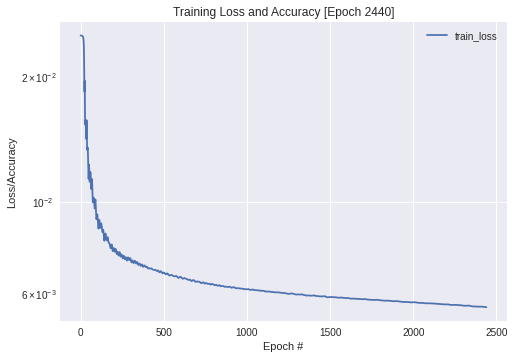

1/1 [==============================] - 0s 166ms/step - loss: 0.0056 - accuracy: 0.8360
Epoch 2442/500000
1/1 [==============================] - 0s 913us/step - loss: 0.0056 - accuracy: 0.8356
Epoch 2443/500000
1/1 [==============================] - 0s 836us/step - loss: 0.0056 - accuracy: 0.8351
Epoch 2444/500000
1/1 [==============================] - 0s 842us/step - loss: 0.0056 - accuracy: 0.8349
Epoch 2445/500000
1/1 [==============================] - 0s 814us/step - loss: 0.0056 - accuracy: 0.8351
Epoch 2446/500000
1/1 [==============================] - 0s 798us/step - loss: 0.0056 - accuracy: 0.8356
Epoch 2447/500000
1/1 [==============================] - 0s 909us/step - loss: 0.0056 - accuracy: 0.8351
Epoch 2448/500000
1/1 [==============================] - 0s 863us/step - loss: 0.0056 - accuracy: 0.8358
Epoch 2449/500000
1/1 [==============================] - 0s 912us/step - loss: 0.0056 - accuracy: 0.8358
Epoch 2450/500000
1/1 [==============================] - 0s 745us/step - 

KeyboardInterrupt: 

In [33]:
#log_dirCNN= model_locCNN + '/logs/' + date_time
#tensorboard_callbackCNN = tf.keras.callbacks.TensorBoard(log_dir=log_dirCNN, histogram_freq=100, update_freq='epoch')
#filepathCNN = model_locCNN + 'weights.{epoch:02d}.hdf5'
#checkpoint_callbackCNN = tf.keras.callbacks.ModelCheckpoint(filepathCNN, verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch',period=100)
start = timeit.default_timer()

mkpath(model_path)
checkpointHistory = tf.keras.callbacks.ModelCheckpoint(model_path+'intLoss{loss:.2E}.hdf5',
                                    monitor='loss', verbose=1, save_best_only=True, mode='auto',save_freq=10000)
checkpointLatest = tf.keras.callbacks.ModelCheckpoint(model_path+'LatestSave4.hdf5', monitor='loss', verbose=1,
    save_best_only=False, mode='auto',save_freq=500)  


csv_logger = CSVLogger(model_path + "log_loss.csv", append=True)
#filePath = 'model-lossSqrt-270K-150Sample.hdf5'
#modelCNN=load_model(model_path+'LatestSave4.hdf5')
scaler1=np.zeros([cellCoeff.shape[0],2],float)
scaler1[:,1]=1.0
#print(scaler1)
init_epoch=500000
Force=np.zeros([X_train.shape[0],intrpAddr.shape[1],2])

bc=np.zeros([X_train.shape[0],bTrac.shape[1],2])


if (unsupervised):
    second_epoch=1000000
    init_one = np.ones([X_train.shape[0],X_train.shape[1],X_train.shape[2],2])
    history = modelCNN.fit([X_train,cellNei_train,cellCoeff_train,bFixed_train,bTrac_train,intrpAddr_train,
                            intrpWei_train, case_init_loss[:n_train]],
                    Force, epochs=init_epoch,batch_size=1000,
                    callbacks=[checkpointHistory,checkpointLatest, csv_logger,plot_losses])
    stop = timeit.default_timer()
    print('Time: ', stop - start)
else:
    modelCNN.fit(X_train,Y_train,epochs=init_epoch,batch_size=256,callbacks=[checkpoint,csv_logger,plot_losses])



In [ ]:
def my_tf_function_factory(model, loss, dataSet):
 
    # now create a function that will be returned by this factory
    
    def func(*params):
        # name2pos = {var.name: i for i, var in enumerate(model.trainable_variables)}
        # update the parameters in the model
        # for name, param in params.items():
        #     model.trainable_variables[name2pos[name]].assign(param)
        for i, param in enumerate(params):
            model.trainable_variables[i].assign(param)

        # calculate the loss
        loss_value, grad = loss(model, dataSet)

        return tf.reduce_mean(loss_value)

    func.trainable_variables = model.trainable_variables
    func.is_keras_functional_model = True

    params = [var.numpy() for var in model.trainable_variables]
    # params = {var.name: var.numpy() for var in model.trainable_variables}
    names = [var.name for var in model.trainable_variables]
    return func, params, names

In [ ]:
import scipy.optimize as sopt
from autograd_minimize.tf_wrapper import tf_function_factory
from autograd_minimize import minimize
from IPython.display import clear_output

allData = (X_train,cellNei_train,cellCoeff_train,bFixed_train,bTrac_train,intrpAddr_train,
                            intrpWei_train, case_init_loss[:n_train])

func, params, names = my_tf_function_factory(modelCNN, loss_and_grad, allData)

# Minimization
res = minimize(
    func,
    params,
    method='L-BFGS-B',
    options = {'maxiter': 5000,
               'maxfun': 5000,
               'disp':1,
               'eps':1e-8,
               'iprint':99,
               'gtol':1e-5,
               'maxcor': 250,
               'maxls': 250,
               'ftol' : 1e-6 * np.finfo(float).eps}
)
print(res)

In [ ]:
# Display the contour plot
#modelCNN.load_weights(filePath)
n=0
n1=0

n2=10

nei=cellNei[n1:n2]#.reshape(-1,cellNei.shape[1],cellNei.shape[2])
coeff=cellCoeff[n1:n2]#.reshape(-1,cellCoeff.shape[1],cellCoeff.shape[2],cellCoeff.shape[3])
fix=bFixed[n1:n2]#.reshape(-1,bFixed.shape[1],bFixed.shape[2])
trac=bTrac[n1:n2]#.reshape(-1,bTrac.shape[1],bTrac.shape[2])
intWei=intrpWei[n1:n2]#.reshape(-1,intrpWei.shape[1],intrpWei.shape[2])
intAdd=intrpAddr[n1:n2]#.reshape(-1,intrpAddr.shape[1],intrpAddr.shape[2])

disp = disp_true[n1:n2].reshape(-1,disp_true.shape[1],disp_true.shape[2])

print(X.shape)
print(coeff.shape)
print(fix.shape)
print(trac.shape)

import pylab
import random
#plt.style.use("classic")

testNum=n2-n1
fig, ax = plt.subplots(testNum,2,figsize=(15, 5*testNum))
#plt.show(block=True)
predictorModel = tf.keras.Model(inputs=modelCNN.input,
                  outputs=modelCNN.get_layer("output1").output)
if (unsupervised):
    y_res=predictorModel.predict([X[n1:n2],nei,coeff,fix,trac,intAdd,intWei])
    y_res_tensor=tf.reshape(tf.constant(y_res,dtype=tf.dtypes.float64),[-1,X_Org.shape[1],X_Org.shape[2],1])
else:
    error=modelCNN.predict(X_Org[n1:n2])
    y_res=predictorModel.predict(X_Org[n1:n2]).reshape(-1,X_Org.shape[1],X_Org.shape[1])


for j in range(n2-n1):
    for k in range(1):
        #n=random.choice(range(1,(n2-n1)))
      

        # List of points in x axis
        #print(X_Org.shape)
        mask=X[n]<0.5
        mask2D=np.stack([mask,mask],-1)
        #print(mask2D.shape)
        
        Ym=np.ma.MaskedArray(y_res[n,:,:,:2],mask2D)
        XPoints = X_Org[n,0,:,0]#*maxXY
        YPoints = X_Org[n,:,0,1]#*maxXY
        #print(YPoints.shape)
        if (unsupervised):
            ZPoints = np.ma.MaskedArray(np.linalg.norm(y_res[n,:,:,:2],axis=-1),mask)#y_res[n,:,:]
            ZPointsX = Ym[:,:,0]#y_res[n,:,:,0]
            ZPointsY = Ym[:,:,1]#y_res[n,:,:,1]
            #print(y_res)
        else:
            ZPointsX = y_res[:,:,0]
            ZPointsY = y_res[:,:,1]

   
        #print((y_res[n,90:,0:10,0]))


        # Set the x axis and y axis limits
        pylab.xlim([np.min(XPoints),np.max(XPoints)])
        pylab.ylim([np.min(YPoints),np.max(YPoints)])

        # Provide a title for the contour plot
        #ax[j,k].set_title('Contour of Phi')

        # Set x axis label for the contour plot
        #ax[j,k].set_xlabel('X')

        # Set y axis label for the contour plot
        #ax[j,k].set_ylabel('Y')

        #contoursY = ax[j,k].contourf(XPoints, YPoints, ZPointsY,20, cmap='jet')
        #contoursX = ax[j,k+1].contourf(XPoints, YPoints, ZPointsX,20, cmap='jet')
        contoursPred = ax[j,k].contourf(XPoints, YPoints, ZPoints,20, cmap='jet')

        #contoursX.autoscale()
        #contoursY.autoscale()
        contoursPred.autoscale()

        #plt.colorbar(contoursY,ax=ax[j,k])
        #plt.colorbar(contoursX,ax=ax[j,k+1])
        plt.colorbar(contoursPred,ax=ax[j,k])

        


        ZTrueSpace = disp_true_crt[n].reshape(Ym.shape)
        ZTrueSpace = np.ma.MaskedArray(ZTrueSpace,mask2D)
        trueDispSpace = np.ma.MaskedArray(np.linalg.norm(ZTrueSpace,axis=-1),mask)#y_res[n,:,:]
        
        trueDispX=ZTrueSpace[:,:,0]
        trueDispY=ZTrueSpace[:,:,1]
        #contoursTrueX = ax[j+1,k+1].contourf(XPoints, YPoints, trueDispX,20, cmap='jet')
        #contoursTrueY = ax[j+1,k].contourf(XPoints, YPoints, trueDispY,20, cmap='jet')
        contoursTrue = ax[j,k+1].contourf(XPoints, YPoints, trueDispSpace,20, cmap='jet')

        contoursTrue.autoscale()        
        plt.colorbar(contoursTrue,ax=ax[j,k+1])
        #plt.colorbar(contoursTrueX,ax=ax[j+1,k+1])
        #plt.colorbar(contoursTrueY,ax=ax[j+1,k])
        
        
    n=n+1
        # Display z values on contour lines
        #ax[j,k].plot.clabel(contours, inline=1, fontsize=10)

#plt.contourf(XPoints, YPoints, ZPointsY, cmap='jet')

       
#plt.show()
#plt.style.use("seaborn")


In [ ]:

def relErr(n1,n2):
  n=0
  nei=cellNei[n1:n2].reshape(-1,cellNei.shape[1],cellNei.shape[2])
  coeff=cellCoeff[n1:n2].reshape(-1,cellCoeff.shape[1],cellCoeff.shape[2],cellCoeff.shape[3])
  fix=bFixed[n1:n2].reshape(-1,bFixed.shape[1],bFixed.shape[2])
  trac=bTrac[n1:n2].reshape(-1,bTrac.shape[1],bTrac.shape[2])
  intWei=intrpWei[n1:n2].reshape(-1,intrpWei.shape[1],intrpWei.shape[2])
  intAdd=intrpAddr[n1:n2].reshape(-1,intrpAddr.shape[1],intrpAddr.shape[2])
  caseInit=case_init_loss[n1:n2].reshape(-1,case_init_loss.shape[1],case_init_loss.shape[2])
  rangeData = no_cell[n1:n2]
  disp = disp_true[n1:n2].reshape(-1,disp_true.shape[1],disp_true.shape[2])

  predictorModel = tf.keras.Model(inputs=modelCNN.input,
                  outputs=modelCNN.get_layer("foam_disp").output)
  if (unsupervised):
    y_res=predictorModel.predict([X[n1:n2],nei,coeff,fix,trac,intAdd,intWei,caseInit])*rangeData
    loss_res=modelCNN.predict([X[n1:n2],nei,coeff,fix,trac,intAdd,intWei,caseInit])
    #print((np.abs(loss_res)))

  else:
    error=modelCNN.predict(X[n1:n2])
    y_res=predictorModel.predict(X[n1:n2]).reshape(-1,X.shape[1],X.shape[1])
    
  magDPred=np.linalg.norm(y_res,axis=-1)
  magDTrue=np.linalg.norm(disp,axis=-1)
 
  disp_max_perCase= np.max(np.abs(magDTrue),axis=1).reshape(-1,1)
  rel_Err = np.abs(magDPred-magDTrue)/disp_max_perCase
  #print("\ny_predict=\n",y_res[1])#.reshape(-1,X.shape[1]*X.shape[2],y_res.shape[3]))
  #print('\ny_OF=\n',disp[1])
  maxMaxRelErr = np.max(rel_Err)*100
  meanMaxRelErr = np.mean(np.max(rel_Err,axis=0))*100
  print('\n\nFor '+str(n2-n1)+' samples:')
  print("\nmeanError%=\n",np.mean(rel_Err)*100)
  print("\nmaxError%=\n",maxMaxRelErr)
  print("\nmeanMaxError%=\n",meanMaxRelErr)
  return meanMaxRelErr,maxMaxRelErr, y_res

trainMeanMaxRelErr,trainMaxRelErr, y_predict= relErr(20,21)
validMeanMaxRelErr,validMaxRelErr, y_test_predict= relErr(n_train,nSample)
cellCoeff[20,0]

In [ ]:
path_case= '/ml_dataset/*/'
       
foam_case_path = glob(path+path_case)[0:10]
print(foam_case_path)
np.random.shuffle(foam_case_path)
cellCoeff_case,cellNei_case,bFixed_case,bTrac_case,disp_true_case,X_case,Y_case,maxI_case,maxJ_case=readAllFoamData(foam_case_path)


bFixedOwner_case=np.sort(bFixed_case[0,:,0].astype(int))
u_case, c_case = np.unique(bFixedOwner_case, return_counts=True)
cellOnceAppeared_case=u_case[c_case!=2]

x_case=np.arange(0,cellNei_case.shape[1])
cellNotAppeared_case=x_case[[z for z in range(x_case.size) if not z in bFixedOwner_case]]
dummyOwner_case=np.concatenate((cellNotAppeared_case,cellNotAppeared_case,cellOnceAppeared_case),axis=0)
arrayDummyOwner_case=np.tile(np.insert(np.zeros([len(dummyOwner_case),bFixed_case.shape[2]-1]),
                                       0,dummyOwner_case,axis=1),(cellNei_case.shape[0],1,1))
z_case=np.concatenate((bFixed_case,arrayDummyOwner_case),axis=1)
bFixedNew2_case=z_case[:,z_case[0,:,0].argsort()].reshape(cellNei_case.shape[0],cellNei_case.shape[1],
                                                          -1,bFixed_case.shape[2])
bTracOwner_case=np.sort(bTrac_case[0,:,0].astype(int))
u_case, c_case = np.unique(bTracOwner_case, return_counts=True)

cellOnceAppeared_case=u_case[c_case!=2]
x_case=np.arange(0,cellNei_case.shape[1])
cellNotAppeared_case=x[[z for z in range(x_case.size) if not z in bTracOwner_case]]
dummyOwner_case=np.concatenate((cellNotAppeared_case,cellNotAppeared_case,cellOnceAppeared_case),axis=0)
arrayDummyOwner_case=np.tile(np.insert(np.zeros([len(dummyOwner_case),
                                    bTrac_case.shape[2]-1]),0,dummyOwner_case,axis=1),(cellNei_case.shape[0],1,1))
z_case=np.concatenate((bTrac_case,arrayDummyOwner_case),axis=1)
bTracNew2_case=z_case[:,z_case[0,:,0].argsort()].reshape(cellNei_case.shape[0],
                                                         cellNei_case.shape[1],-1,bTrac_case.shape[2])

#disp_true_case[0,0,0]=1e-7
disp_true_tensor_case=tf.reshape(tf.constant(disp_true_case),[-1,X_train.shape[1],X_train.shape[2],3])
#print("\nDisp=",disp_true_tensor_case.eval(session=tf.compat.v1.Session()))
#disp_true


In [ ]:
model = tf.keras.models.load_model(model_path+'LatestSave4.hdf5')
tf.saved_model.save(modelCNN, 'dsdsdsd')